In [1]:
from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy
import torch
from uncertaintylearning.utils import (FixedKernelDensityEstimator, CVKernelDensityEstimator,
                                       create_network, create_optimizer, create_multiplicative_scheduler)
from uncertaintylearning.models import EpistemicPredictor
from torch.utils.data import DataLoader, TensorDataset


In [2]:
def oracle(x, noise=0.1):
    # returns sin(2pi x) + epsilon with epsilon ~ N(0, 0.1)
    with torch.no_grad():
        m = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1]))
        m = m.sample((x.size(0),))
        return (2 * np.pi * x).sin() + noise * m

def generate_data(n=1024, sep=1):
    # generate data from U([0, 1/2] union U([1/2 + sep, 1 + sep]))
    # sep needs to be < 1.5
    with torch.no_grad():
        x = torch.zeros(n // 2, 1).uniform_(0, 0.5)
        x = torch.cat((x, torch.zeros(n // 2, 1).uniform_(0.5 + sep, 1 + sep)), 0)
        x_test = torch.linspace(-0.5, 2.5, 512).view(-1, 1)
        ood_x = torch.FloatTensor(512, 1).uniform_(-0.5, 2.5)
        y = oracle(x)
        y2 = oracle(x)
        ood_y = oracle(ood_x)
        y_test_true = oracle(x_test, noise=0)
        return x, y, y2, x_test, y_test_true, ood_x, ood_y

x, y, y2, x_test, y_test, ood_x, ood_y = generate_data()

In [3]:
density_estimator = CVKernelDensityEstimator()
additional_data = {'train_Y_2': y2,
                  'ood_X': ood_x,
                  'ood_Y': ood_y}
networks = {'a_predictor': create_network(1, 1, 32, 'tanh', True),
            'e_predictor': create_network(2, 1, 32, 'relu', True),
            'f_predictor': create_network(1, 1, 64, 'relu', False)
            }

optimizers = {'a_optimizer': create_optimizer(networks['a_predictor'], 1e-2),
              'e_optimizer': create_optimizer(networks['e_predictor'], 3e-3),
              'f_optimizer': create_optimizer(networks['f_predictor'], 1e-3)
              }
schedulers = {'e_scheduler': create_multiplicative_scheduler(optimizers['e_optimizer'],
                                                            lr_schedule=0.999)
}
epistemic_predictor = EpistemicPredictor(x, y, additional_data, networks, optimizers, density_estimator)

In [4]:
epistemic_predictor.pretrain_density_estimator(x)

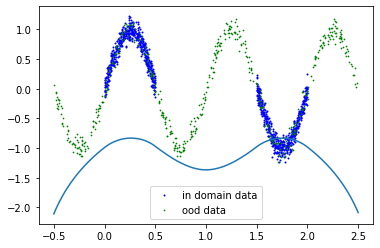

In [5]:
plt.scatter(x, y, color='b', s=1, label='in domain data')
plt.scatter(ood_x, ood_y, color='g', s=.5, label='ood data')
plt.plot(x_test, density_estimator.score_samples(x_test))
plt.legend()
plt.show()


In [7]:
epochs = 1

for i in range(epochs):
    losses = epistemic_predictor.fit()


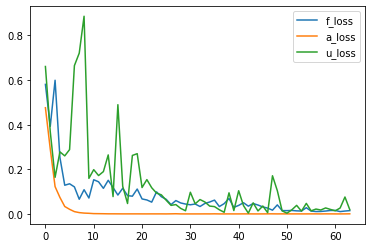

In [8]:
plt.plot(losses['f'], label='f_loss')
plt.plot(losses['a'], label='a_loss')
plt.plot(losses['e'], label='u_loss')
plt.legend()
plt.show()

In [9]:
predictions = networks['f_predictor'](x_test).detach().numpy().ravel()

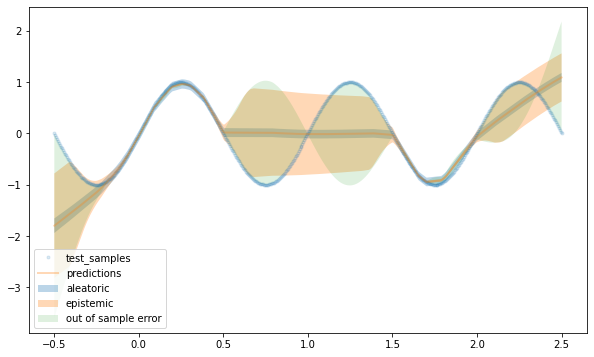

In [10]:
plt.figure(figsize=(10, 6))

aleatoric_u = networks['a_predictor'](x_test).detach().numpy().ravel()
a_low = predictions - np.sqrt(aleatoric_u)
a_high = predictions + np.sqrt(aleatoric_u)

plt.plot(x_test, y_test, '.', label='test_samples', alpha=.15)
plt.plot(x_test, predictions, label='predictions', alpha=.3, lw=2)
plt.fill_between(x_test.numpy().ravel(), a_low, a_high, alpha=.3, label='aleatoric')

test_den = torch.FloatTensor(density_estimator.score_samples(x_test.numpy()).reshape(-1, 1))
e_in = torch.cat((x_test.view(-1, 1), test_den), axis=1)
epistemic_u = networks['e_predictor'](e_in).detach().numpy().ravel()

e_low = predictions - np.sqrt(epistemic_u)
e_high = predictions + np.sqrt(epistemic_u)

plt.fill_between(x_test.numpy().ravel(), e_low, e_high, alpha=.3, label='epistemic')

exp_epistemic_uncertainty = (networks['f_predictor'](x_test) - y_test).pow(2).detach().numpy().ravel()
exp_total_uncertainty = exp_epistemic_uncertainty + 0.1

exp_e_low = predictions - np.sqrt(exp_epistemic_uncertainty)
exp_e_high = predictions + np.sqrt(exp_epistemic_uncertainty)

plt.fill_between(x_test.numpy().ravel(), exp_e_low, exp_e_high, alpha=.15, label='out of sample error')

plt.legend()
plt.show()

total_uncertainty = epistemic_u + aleatoric_u


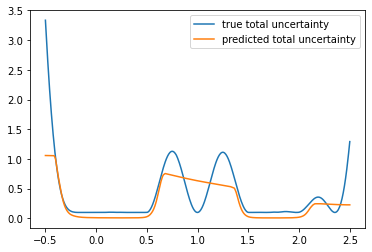

In [11]:
plt.plot(x_test, exp_total_uncertainty, label='true total uncertainty')
plt.plot(x_test, total_uncertainty, label='predicted total uncertainty')
plt.legend()
plt.show()

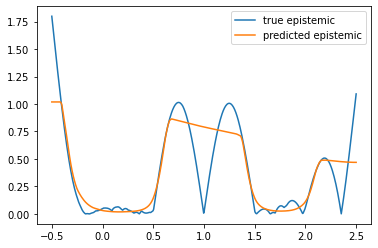

In [12]:
plt.plot(x_test.view(-1).numpy(), np.sqrt(exp_epistemic_uncertainty), label='true epistemic')
plt.plot(x_test.view(-1).numpy(), np.sqrt(epistemic_u), label='predicted epistemic')
plt.legend()
plt.show()